# Part 1

In [25]:
import numpy as np

import torch
import torch.nn.functional as F 
from torch import nn

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## Question 3

In [2]:
# create input data
X = torch.arange(1,10, dtype=torch.float32).reshape(-1,3)
X = torch.stack([X, 2*X]) # 2 channels
X = torch.stack([X, 4*X]) # 2 batches
X.requires_grad = True
X

tensor([[[[ 1.,  2.,  3.],
          [ 4.,  5.,  6.],
          [ 7.,  8.,  9.]],

         [[ 2.,  4.,  6.],
          [ 8., 10., 12.],
          [14., 16., 18.]]],


        [[[ 4.,  8., 12.],
          [16., 20., 24.],
          [28., 32., 36.]],

         [[ 8., 16., 24.],
          [32., 40., 48.],
          [56., 64., 72.]]]], requires_grad=True)

In [3]:
# non vectorized unfolding
# shape [b,p,k] as specified in the task, opposed to the torch.Unfold, that creates a [b,k,p] matrix

batch_size = X.shape[0]
n_channels = X.shape[1]
h = X.shape[2]
w = X.shape[3]

def unfold(X, kernel_size, stride=1, padding=0):
    batch_size,n_channels,h,w = X.shape
    res = []
    for b in range(batch_size):
        cur_batch = []
        for row_start in range(0-padding, h + padding - kernel_size[0] + 1, stride):
            for col_start in range(0-padding, w + padding - kernel_size[1] + 1, stride):
                cur_row = []
                for ch in range(n_channels):
                    for r in range(row_start, row_start+kernel_size[0]):
                        for c in range(col_start, col_start+kernel_size[1]):
                            if r < 0 or r >= h or c < 0 or c >= h:
                                cur_row.append(0)
                            else:
                                cur_row.append(X[b,ch,r,c])
                cur_batch.append(cur_row[:])
        res.append(cur_batch[:])
    return res


out = unfold(X, kernel_size=(2,2), stride=1, padding=0)
torch.tensor(out)
    

tensor([[[ 1.,  2.,  4.,  5.,  2.,  4.,  8., 10.],
         [ 2.,  3.,  5.,  6.,  4.,  6., 10., 12.],
         [ 4.,  5.,  7.,  8.,  8., 10., 14., 16.],
         [ 5.,  6.,  8.,  9., 10., 12., 16., 18.]],

        [[ 4.,  8., 16., 20.,  8., 16., 32., 40.],
         [ 8., 12., 20., 24., 16., 24., 40., 48.],
         [16., 20., 28., 32., 32., 40., 56., 64.],
         [20., 24., 32., 36., 40., 48., 64., 72.]]])

In [4]:
F.unfold(X, kernel_size=2)

tensor([[[ 1.,  2.,  4.,  5.],
         [ 2.,  3.,  5.,  6.],
         [ 4.,  5.,  7.,  8.],
         [ 5.,  6.,  8.,  9.],
         [ 2.,  4.,  8., 10.],
         [ 4.,  6., 10., 12.],
         [ 8., 10., 14., 16.],
         [10., 12., 16., 18.]],

        [[ 4.,  8., 16., 20.],
         [ 8., 12., 20., 24.],
         [16., 20., 28., 32.],
         [20., 24., 32., 36.],
         [ 8., 16., 32., 40.],
         [16., 24., 40., 48.],
         [32., 40., 56., 64.],
         [40., 48., 64., 72.]]], grad_fn=<Im2ColBackward0>)

In [5]:
class Conv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3), stride=1, padding=1): 
        assert padding >= 0, "negative padding is not supported"
        super(Conv2D, self).__init__()
        self.weights = torch.ones(in_channels * kernel_size[0] * kernel_size[1], out_channels, requires_grad=True)
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.out_channels = out_channels
    
    def forward(self, input_batch):
        b, c, h, w = input_batch.size()
        
        self.input = input_batch
        self.input.requires_grad = True
        assert h + 2*self.padding >= self.kernel_size[0], \
            f"Calculated padded input size per channel: ({h+2*self.padding}x{w+2*self.padding})." \
            f" Kernel size: ({self.kernel_size[0]} x {self.kernel_size[1]})." \
            f" Kernel size can't be greater than actual input size"
        assert w + 2*self.padding >= self.kernel_size[1], \
            f"Calculated padded input size per channel: ({h+2*self.padding}x{w+2*self.padding})." \
            f" Kernel size: ({self.kernel_size[0]} x {self.kernel_size[1]})." \
            f" Kernel size can't be greater than actual input size"        
        
        X = F.unfold(input_batch, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        X = torch.permute(X, (0,2,1)) # Transpose laset 2 dims
        Y = torch.matmul(X, self.weights)
        out_height = int((h+2*self.padding-self.kernel_size[0])/self.stride + 1)
        return torch.permute(Y, dims=(0,2,1)).reshape(b, self.out_channels, out_height, -1)
        

conv = Conv2D(in_channels=2, out_channels=1, kernel_size=(2,2), padding=1, stride=1)
input_batch = X.clone().detach().requires_grad_(True)
output_batch = conv(input_batch)
output_batch.backward(torch.ones(output_batch.shape))
output_batch

tensor([[[[  3.,   9.,  15.,   9.],
          [ 15.,  36.,  48.,  27.],
          [ 33.,  72.,  84.,  45.],
          [ 21.,  45.,  51.,  27.]]],


        [[[ 12.,  36.,  60.,  36.],
          [ 60., 144., 192., 108.],
          [132., 288., 336., 180.],
          [ 84., 180., 204., 108.]]]], grad_fn=<ReshapeAliasBackward0>)

## Question 6

In [6]:
class Conv2DFunc(torch.autograd.Function): 
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward
    passes which operate on Tensors.
    """
    
    @staticmethod
    def forward(ctx, input_batch, kernel, stride=1, padding=1): 
        """
        In the forward pass we receive a Tensor containing the input
        and return a Tensor containing the output. ctx is a context
        object that can be used to stash information for backward
        computation. You can cache arbitrary objects for use in the
        backward pass using the ctx.save_for_backward method.
        """
        
        # your code here
        h = input_batch.shape[2]
        batch_size = input_batch.shape[0]
        out_channels = kernel.shape[0]
        kernel_size = kernel.shape[-2:]
        
        input_batch_folded = F.unfold(input_batch, kernel_size=kernel_size, stride=stride, padding=padding)
        input_batch_folded = torch.permute(input_batch_folded, (0,2,1)) # Transpose laset 2 dims
        weights = kernel.reshape(-1, kernel.shape[0])
        Y = torch.matmul(input_batch_folded, weights)
        
        params = torch.tensor([stride, padding])
        ctx.save_for_backward(input_batch, input_batch_folded, weights, torch.tensor(kernel.shape), params)
        
        
        out_height = int((h+2*padding-kernel_size[0])/stride + 1)
        return torch.permute(Y, dims=(0,2,1)).reshape(batch_size, out_channels, out_height, -1)

    @staticmethod
    def backward(ctx, grad_output): 
        """
        In the backward pass we receive a Tensor containing the
        gradient of the loss with respect to the output, and we need
        to compute the gradient of the loss with respect to the
        input
        """
        input_batch, input_batch_folded, weights, kernel_shape, params = ctx.saved_tensors 
        
        stride, padding = int(params[0]), int(params[1])
        ch_out, ch_in = kernel_shape[:2]
        kernel_size = kernel_shape[2:]
        b = grad_output.shape[0]
        h,w = grad_output.shape[2:]
        
        grad_output = grad_output.reshape(b, h*w, -1) # [batch, h*w, out_ch]
        input_batch_grad_unfolded = torch.matmul(grad_output, weights.T)
        input_batch_T = torch.permute(input_batch_folded, (0,2,1))
        weights_grad = torch.matmul(input_batch_T, grad_output).sum(axis=0)

        input_batch_grad = F.fold(input_batch_grad_unfolded.permute(0,2,1), output_size=(input_batch.shape[2:]), 
                                  kernel_size=(kernel_size), stride=stride, padding=padding)
        kernel_grad = weights_grad.reshape(list(kernel_shape))
        
        # The gradients of the inputs. For anything that doesn't have # a gradient (the stride and padding) you can
        # return None.
        return input_batch_grad, kernel_grad, None, None
    
    
input_batch = X.clone().detach().requires_grad_(True)
kernel = torch.ones(1,2,2,2, requires_grad=True) # [ch_out, ch_in, kernel_h, kernel_w]
res = Conv2DFunc.apply(input_batch, kernel)
res.backward(torch.ones(res.shape))
res


tensor([[[[  3.,   9.,  15.,   9.],
          [ 15.,  36.,  48.,  27.],
          [ 33.,  72.,  84.,  45.],
          [ 21.,  45.,  51.,  27.]]],


        [[[ 12.,  36.,  60.,  36.],
          [ 60., 144., 192., 108.],
          [132., 288., 336., 180.],
          [ 84., 180., 204., 108.]]]], grad_fn=<Conv2DFuncBackward>)

# Part 2

## Question 7

In [7]:
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.optim as optim

bs = 16

train = torchvision.datasets.MNIST(root='.data/', train=True, download=True, transform=ToTensor()) 
train, val = torch.utils.data.random_split(train, (50000, 10000))
test = torchvision.datasets.MNIST(root='.data/', train=False, download=True, transform=ToTensor())

trainloader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=bs, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=bs, shuffle=True, num_workers=2)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 3 * 3, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x

In [193]:
def train_net(net, trainloader, valloader, epochs, criterion, optimizer):
    train_loss_per_epoch = []
    val_loss_per_epoch = []
    print('Training...')
    for epoch in range(epochs):  # loop over the dataset multiple times
        # train
        losses = []
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        train_loss_per_epoch.append(sum(losses) / len(losses)) # avg train loss per epoch
        
        # val
        losses = []
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            
        val_loss_per_epoch.append(sum(losses) / len(losses)) # avg train loss per epoch
        print(f"Epoch {epoch+1}:  train loss: {train_loss_per_epoch[-1]:.3f}, val loss: {val_loss_per_epoch[-1]:.3f}")
        
    print('Finished Training')
    return train_loss_per_epoch, val_loss_per_epoch

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
train_loss_q7, val_loss_q7 = train_net(net, trainloader, valloader, 5, criterion, optimizer)


Training...
Epoch 1:  train loss: 0.141, val loss: 0.058
Epoch 2:  train loss: 0.046, val loss: 0.048
Epoch 3:  train loss: 0.034, val loss: 0.050
Epoch 4:  train loss: 0.027, val loss: 0.037
Epoch 5:  train loss: 0.022, val loss: 0.048
Finished Training


In [194]:
def plot_train_val_loss(train_loss, val_loss, question):
    fig, ax = plt.subplots()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax.plot(range(1, len(train_loss)+1), train_loss, label = 'train loss')
    ax.plot(range(1, len(val_loss)+1), val_loss, label = 'val loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Avg. Loss')
    plt.xlim(1, len(train_loss))
    plt.legend()
    plt.savefig('Q' + str(question) + '.png')

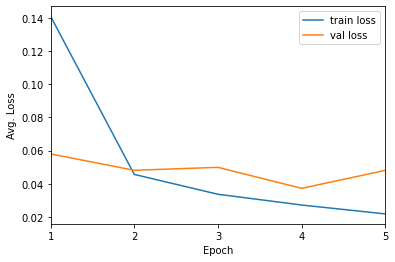

In [195]:
plot_train_val_loss(train_loss_q7, val_loss_q7, 7)

In [196]:
def test_net(net, testloader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    print(f'Accuracy of the network on the test images: {100 * acc} %')
    return acc
    
test_net(net, testloader)

Accuracy of the network on the test images: 99.03 %


0.9903

## Question 8

Network in Question 7 already produces 99% accuracy, no need to further optimise hyperparameters

## Question 9

In [182]:
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
#      torchvision.transforms.Compose([transforms.CenterCrop(24), transforms.Pad(padding=2)]),
     transforms.RandomRotation(degrees=(-25, 25))
    ])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

In [183]:
bs = 16

train = torchvision.datasets.MNIST(root='.data/', train=True, download=True) 
train, val = torch.utils.data.random_split(train, (50000, 10000))
train.dataset.transform = train_transform
val.dataset.transform = test_transform
test = torchvision.datasets.MNIST(root='.data/', train=False, download=True, transform=test_transform)

trainloader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=bs, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=bs, shuffle=True, num_workers=2)

In [184]:
# Train
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
train_loss_q9, val_loss_q9 = train_net(net, trainloader, valloader, 5, criterion, optimizer)
test_net(net, testloader)

Training...
Epoch 1, train loss: 0.150, val loss: 0.055
Epoch 2, train loss: 0.047, val loss: 0.051
Epoch 3, train loss: 0.035, val loss: 0.047
Epoch 4, train loss: 0.027, val loss: 0.050
Epoch 5, train loss: 0.022, val loss: 0.036
Finished Training
Accuracy of the network on the test images: 99.00999999999999 %


0.9901

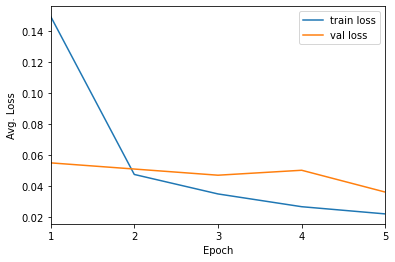

In [192]:
plot_train_val_loss(train_loss_q9, val_loss_q9, 9)

In [ ]:
img, lbl = next(iter(trainloader))

In [ ]:
plt.imshow(img[4].squeeze(0))

In [ ]:
lbl[4]

## Question 10

In [ ]:
inp = torch.randn(1,3,768,1024)
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=1, stride=2)
conv(inp).shape

In [ ]:
inp = torch.randn(1,3,1080,1920)
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=1, stride=2)
conv(inp).shape

## Question 11

In [37]:
max_pooled = X.amax(dim=(2,3))  # Global max pool
mean_pooled = X.mean(dim=(2,3))  # Global mean pool

## Question 12

In [38]:
# download dataset
import os
import urllib
import tarfile

url = 'https://dlvu.github.io/data/mnist-varres.tgz'
file = 'mnist-varres.tgz'
if not os.path.isdir('mnist-varres'):
    print(f'Downloading {url} and saving as {file}...')
    urllib.request.urlretrieve(url, file)
    
    print('Unzipping images...')
    with tarfile.open(file) as tar:
        tar.extractall()
    
    os.remove(file)
    print('Done!')

In [48]:
from torchvision.datasets import ImageFolder

transform = transforms.Compose([transforms.Resize(28),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()
                               ])


train = ImageFolder(root='mnist-varres/train', transform=transform)
train, val = torch.utils.data.random_split(train, (50000, 10000))
test = ImageFolder(root='mnist-varres/test', transform=transform)

trainloader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=bs, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=bs, shuffle=True, num_workers=2)

In [54]:
t = transforms.Resize(28)

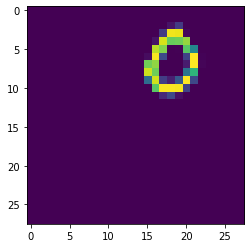

In [55]:
plt.imshow(t(torch.tensor(np.expand_dims(plt.imread(train.dataset.imgs[0][0]), (0,1))))[0,0])
plt.savefig('digit0_64_resized')

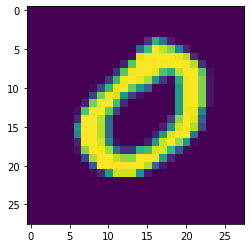

In [56]:
plt.imshow(t(torch.tensor(np.expand_dims(plt.imread(train.dataset.imgs[3][0]), (0,1))))[0,0])
plt.savefig('digit0_32_resized')

In [57]:
# Train
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
train_loss_q12, val_loss_q12 = train_net(net, trainloader, valloader, 5, criterion, optimizer)
test_net(net, testloader)

Training...
Epoch 1, train loss: 0.597, val loss: 0.285
Epoch 2, train loss: 0.228, val loss: 0.196
Epoch 3, train loss: 0.156, val loss: 0.151
Epoch 4, train loss: 0.119, val loss: 0.142
Epoch 5, train loss: 0.095, val loss: 0.110
Finished Training
Accuracy of the network on the test images: 97.13000000000001 %


0.9713

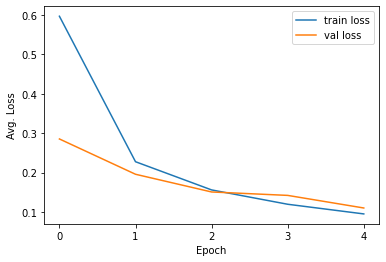

In [58]:
plot_train_val_loss(train_loss_q12, val_loss_q12, 12)

## Question 13

In [59]:
def create_dataloaders_per_res(dataset):
    # create dict {size: (path, label)}
    img_size_to_path = defaultdict(list)
    for path, label in dataset.imgs:
        size = plt.imread(path).shape[-1] 
        img_size_to_path[size].append((path, label))
        
    # create dict {size: separate pytorch Dataset}
    dataset_per_res = {}
    for size in img_size_to_path:
        dataset_per_res[size] = copy.deepcopy(train)
        dataset_per_res[size].imgs = img_size_to_path[size]
        dataset_per_res[size].samples = img_size_to_path[size]
        
    # create dict {size: pytorch Dataloader}
    dataloaders = {}
    for size in dataset_per_res:
        dataloaders[size] = torch.utils.data.DataLoader(dataset_per_res[size], batch_size=bs, shuffle=True, num_workers=2)
    
    return dataloaders

In [265]:
# separate dataloader for every resolution

from collections import defaultdict
import copy


transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()
                               ])

# load all images as pytorch Dataset
train = ImageFolder(root='mnist-varres/train', transform=transform)
train_subset, val_subset = torch.utils.data.random_split(train, (50000, 10000))
train_subset.imgs = [train.imgs[i] for i in train_subset.indices]
train_subset.samples = [train.samples[i] for i in train_subset.indices]
val_subset.imgs = [train.imgs[i] for i in val_subset.indices]
val_subset.samples = [train.samples[i] for i in val_subset.indices]

test = ImageFolder(root='mnist-varres/test', transform=transform)

trainloaders = create_dataloaders_per_res(train_subset)
valloaders = create_dataloaders_per_res(val_subset)
testloaders = create_dataloaders_per_res(test)

In [266]:
# load images to 3 tensor (separate per image size)

# from collections import defaultdict
# import copy

# # load all images as pytorch Dataset
# train = ImageFolder(root='mnist-varres/train', transform=transform)
# test = ImageFolder(root='mnist-varres/test', transform=transform)

# # create dict {size: (path, label)}
# img_train_per_res = [[] for _ in range(3)]
# img_test_per_res = [[] for _ in range(3)]
# label_train_per_res = [[] for _ in range(3)]
# label_test_per_res = [[] for _ in range(3)]


# for path, label in train.imgs:
#     img = plt.imread(path)
#     size = img.shape[-1]
#     if size == 32:
#         img_train_per_res[0].append(torch.tensor(img))
#         label_train_per_res[0].append(label)
#     elif size == 48:
#         img_train_per_res[1].append(torch.tensor(img))
#         label_train_per_res[1].append(label)
#     else:
#         img_train_per_res[2].append(torch.tensor(img))
#         label_train_per_res[2].append(label)
        
        
# for path, label in test.imgs:
#     img = plt.imread(path)
#     size = img.shape[-1]
#     if size == 32:
#         img_test_per_res[0].append(torch.tensor(img))
#         label_test_per_res[0].append(label)
#     elif size == 48:
#         img_test_per_res[1].append(torch.tensor(img))
#         label_test_per_res[1].append(label)
#     else:
#         img_test_per_res[2].append(torch.tensor(img))
#         label_test_per_res[2].append(label)

## Question 14

In [267]:
N = 64
global_pooling = torch.amax

class Net_varres(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=N, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(N, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = global_pooling(x, dim=(-1,-2))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x

In [268]:
def train_varres(net, trainloaders, valloaders, epochs, criterion, optimizer):
    train_loss_per_epoch = []
    val_loss_per_epoch = []
    print('Training...')
    for epoch in range(epochs):  # loop over the dataset multiple times
        # train
        losses = []
        for size, trainloader in trainloaders.items():
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                losses.append(loss.item())
                loss.backward()
                optimizer.step()
        
        train_loss_per_epoch.append(sum(losses) / len(losses)) # avg train loss per epoch
        
        # val
        losses = []
        for size, valloader in valloaders.items():
            for i, data in enumerate(valloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data

                outputs = net(inputs)
                loss = criterion(outputs, labels)
                losses.append(loss.item())
                
        val_loss_per_epoch.append(sum(losses) / len(losses)) # avg train loss per epoch
        print(f"Epoch {epoch+1}:  train loss: {train_loss_per_epoch[-1]:.3f}, val loss: {val_loss_per_epoch[-1]:.3f}")
    
    print('Finished Training')
    return train_loss_per_epoch, val_loss_per_epoch

In [269]:
def test_varres(net, testloaders):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for size, testloader in testloaders.items():
            for data in testloader:
                images, labels = data
                # calculate outputs by running images through the network
                outputs = net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    acc = correct / total
    print(f'Accuracy of the network on the test images: {100 * acc:.3f} %')
    return acc

In [270]:
# Train
net_varres = Net_varres()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_varres.parameters())
train_loss_q14, val_loss_q14 = train_varres(net_varres, trainloaders, valloaders, 5, criterion, optimizer)

Training...
Epoch 1:  train loss: 0.268, val loss: 0.108
Epoch 2:  train loss: 0.082, val loss: 0.056
Epoch 3:  train loss: 0.059, val loss: 0.048
Epoch 4:  train loss: 0.049, val loss: 0.044
Epoch 5:  train loss: 0.038, val loss: 0.058
Finished Training


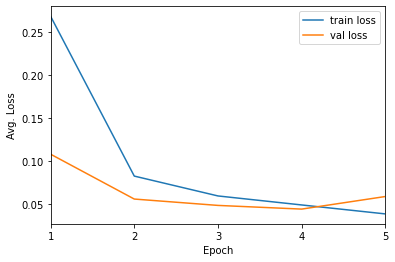

In [271]:
plot_train_val_loss(train_loss_q14, val_loss_q14, 14)

In [272]:
test_varres(net_varres, testloaders)

Accuracy of the network on the test images: 97.900 %


0.979

## Question 15


In [ ]:
# Number of weights
# conv1 1x3x3x16 + 16 = 160
# conv2 16x3x3x32 + 32 = 4640
# conv3 32x3x3x64 + 64 = 18496
# fc1 643x3x10 + 10 = 5770
# SUM = 29066


# Number of weights varres
# conv1 1x3x3x16 + 16 = 160
# conv2 16x3x3x32 + 32 = 4640
# conv3 32x3x3xN + N = 289N
# fc1 10xN + 10 = 11N

# N = (29066 - 160 - 4640) / 300 = 80.89 

In [273]:
N = 81

In [274]:
net_varres = Net_varres()
s = 0
for param in net_varres.parameters():
    s += (np.prod(param.shape))
s

29029

## Question 16

Training...
Epoch 1:  train loss: 0.262, val loss: 0.084
Epoch 2:  train loss: 0.078, val loss: 0.077
Epoch 3:  train loss: 0.055, val loss: 0.054
Epoch 4:  train loss: 0.044, val loss: 0.052
Epoch 5:  train loss: 0.035, val loss: 0.049
Finished Training
Accuracy of the network on the test images: 98.740 %


0.9874

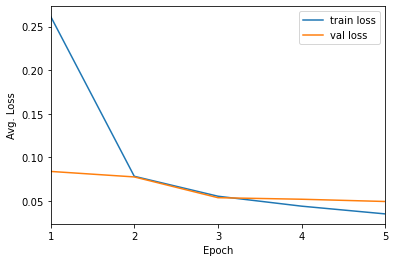

In [275]:
global_pooling = torch.amax

net_varres = Net_varres()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_varres.parameters())
train_loss_q16_max, val_loss_q16_max = train_varres(net_varres, trainloaders, valloaders, 5, criterion, optimizer)
plot_train_val_loss(train_loss_q16_max, val_loss_q16_max, 16.1)
test_varres(net_varres, testloaders)

Training...
Epoch 1:  train loss: 0.580, val loss: 0.290
Epoch 2:  train loss: 0.208, val loss: 0.212
Epoch 3:  train loss: 0.152, val loss: 0.153
Epoch 4:  train loss: 0.116, val loss: 0.128
Epoch 5:  train loss: 0.097, val loss: 0.098
Finished Training
Accuracy of the network on the test images: 97.950 %


0.9795

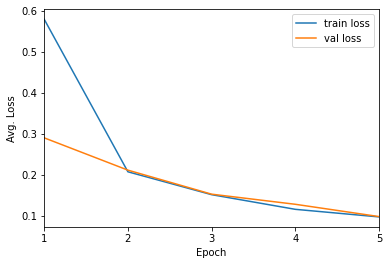

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe7ca5c5dc0>
Traceback (most recent call last):
  File "/Users/agoston/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/Users/agoston/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1424, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


In [282]:
global_pooling = torch.mean

net_varres = Net_varres()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_varres.parameters())
accuracies_mean = []

train_loss_q16_mean, val_loss_q16_mean = train_varres(net_varres, trainloaders, valloaders, 5, criterion, optimizer)
plot_train_val_loss(train_loss_q16_mean, val_loss_q16_mean, 16.2)
test_varres(net_varres, testloaders)

In [283]:
# Max pooling performed better, thus
global_pooling = torch.amax

## Question 17

Training...
Epoch 1:  train loss: 0.667, val loss: 0.365
Epoch 2:  train loss: 0.266, val loss: 0.340
Epoch 3:  train loss: 0.187, val loss: 0.205
Epoch 4:  train loss: 0.149, val loss: 0.176
Epoch 5:  train loss: 0.122, val loss: 0.140
Finished Training
Accuracy of the network on the test images: 96.24000000000001 %


0.9624

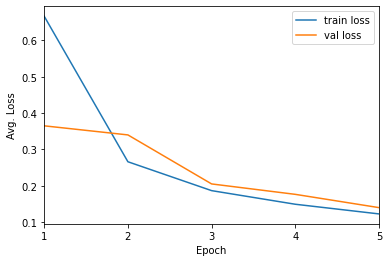

In [284]:
# resize to same size (from Question 12)
transform = transforms.Compose([transforms.Resize(28),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()
                               ])


train = ImageFolder(root='mnist-varres/train', transform=transform)
train, val = torch.utils.data.random_split(train, (50000, 10000))
test = ImageFolder(root='mnist-varres/test', transform=transform)

bs = 16
trainloader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=bs, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=bs, shuffle=True, num_workers=2)


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

train_loss_q17, val_loss_q17 = train_net(net, trainloader, valloader, 5, criterion, optimizer)
plot_train_val_loss(train_loss_q17, val_loss_q17, 17.1)
test_net(net, testloader)

Training...
Epoch 1:  train loss: 0.280, val loss: 0.108
Epoch 2:  train loss: 0.082, val loss: 0.070
Epoch 3:  train loss: 0.060, val loss: 0.055
Epoch 4:  train loss: 0.048, val loss: 0.058
Epoch 5:  train loss: 0.038, val loss: 0.049
Finished Training
Accuracy of the network on the test images: 98.720 %


0.9872

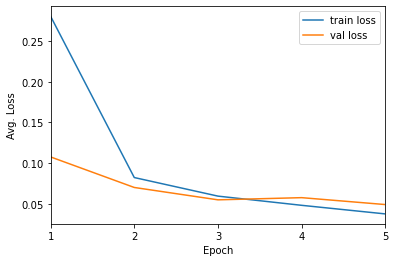

In [285]:
# var res net

net_varres = Net_varres()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_varres.parameters())
train_loss_q17_varres, val_loss_q17_varres = train_varres(net_varres, trainloaders, valloaders, 5, criterion, optimizer)
plot_train_val_loss(train_loss_q17_varres, val_loss_q17_varres, 17.2)
test_varres(net_varres, testloaders)